In [2]:
import csv
import pandas as pd
import numpy as np
import os
import random as rd
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import wordcloud
import community
import math
import powerlaw
import urllib.request
import json
import re
import operator
from scipy import stats
from fa2 import ForceAtlas2
import warnings
warnings.filterwarnings('ignore')

# Getting sentiment data and merging with graph

In [3]:
sent_df = pd.read_csv('..\\sentiment_ion.csv', sep=';')
sent_df.drop(columns=['Unnamed: 0'], inplace=True)
sent_df = sent_df.dropna(axis=0, subset=['text'])

In [4]:
df = pd.read_pickle("connections.pkl")
poli = df[['name','group', 'chamber','links']]
final_df = pd.merge(sent_df, poli, on='name', how='left')

In [5]:
df_text_by_url = final_df.groupby(['url'], as_index=False).agg({'text': ' '.join})

In [6]:
news_party = final_df.groupby(['url','group'], as_index=False).agg({'text': ' '.join})
news_party.head()


,url,group,text
0,abc17news.com,Republican,"COLUMBIA, Mo. (KMIZ)\r\n\r\nGov. Mike Parson j..."
1,abc7ny.com,Democrat,"Ritchie Torres, Mondaire Jones make LGBTQ hist..."
2,abcnews.go.com,Democrat,There are least 210 House Democrats now callin...
3,abcnews.go.com,Republican,The two sides agreed to not call witnesses.\r\...
4,about.bgov.com,Democrat,Sen. Wicker entertains narrow injunctive relie...


In [8]:
# Getting the top 5 news papers
top5 = ['www.nytimes.com', 'www.washingtonpost.com', 'www.npr.org', 'www.cnn.com', 'abcnews.go.com']
news_party = news_party.loc[news_party['url'].isin(top5)]
news_party.drop(news_party.loc[news_party['group'] == 'Independent'].index, inplace=True)
news_party.head()

,url,group,text
2,abcnews.go.com,Democrat,There are least 210 House Democrats now callin...
3,abcnews.go.com,Republican,The two sides agreed to not call witnesses.\r\...
212,www.cnn.com,Democrat,CNN —\r\n\r\nLawmakers in the House voted over...
214,www.cnn.com,Republican,Washington CNN —\r\n\r\nFederal prosecutors on...
390,www.npr.org,Democrat,'Freed From The Secret': Rep. Ayanna Pressley ...


# Pairwise TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud
##stopwords = set(wordcloud.STOPWORDS)


def make_wordcloud(text, stopwords):
    # Create a TfidfVectorizer object only using ascii and removing set stopwords. Only words more than 3 chars as well.
    vectorizer = TfidfVectorizer(strip_accents = "ascii", stop_words=stopwords, lowercase = True, token_pattern=r'(?u)\b\w{4,}\b')
    # Fit the vectorizer
    vectorizer.fit(text['text'])
    feature_names = vectorizer.get_feature_names()

    # Transform the text data to tf-idf
    tfidf_matrix = vectorizer.transform(text['text'])

    dense = tfidf_matrix.todense()
    lst = dense.tolist()
    tf_df = pd.DataFrame(lst, columns=feature_names)
    
    list_of_wordsclouds = []
    for i in range(0, 2):
        word_string = ''.join([(w+' ')*(math.ceil(c*50000)) for w,c in dict(tf_df.iloc[i]).items()])
        cloud = wordcloud.WordCloud(collocations = False, background_color='white',  max_words=100, color_func=lambda *args, **kwargs: "black").generate(word_string)
        list_of_wordsclouds.append(cloud)
    
    return list_of_wordsclouds

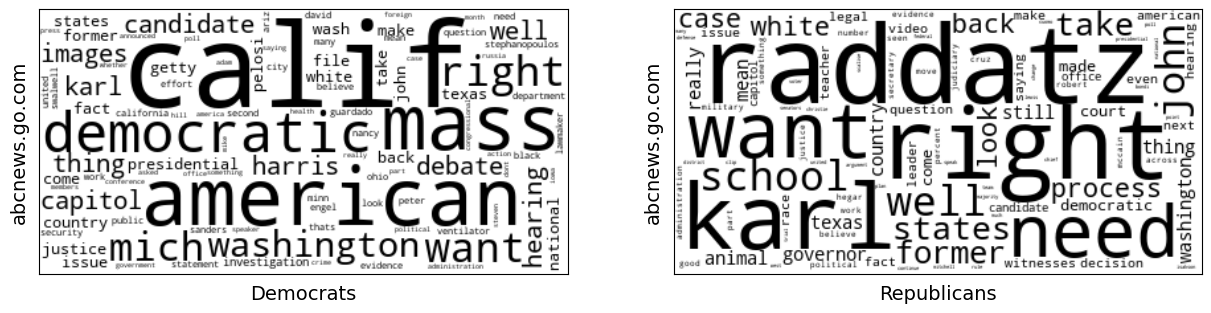

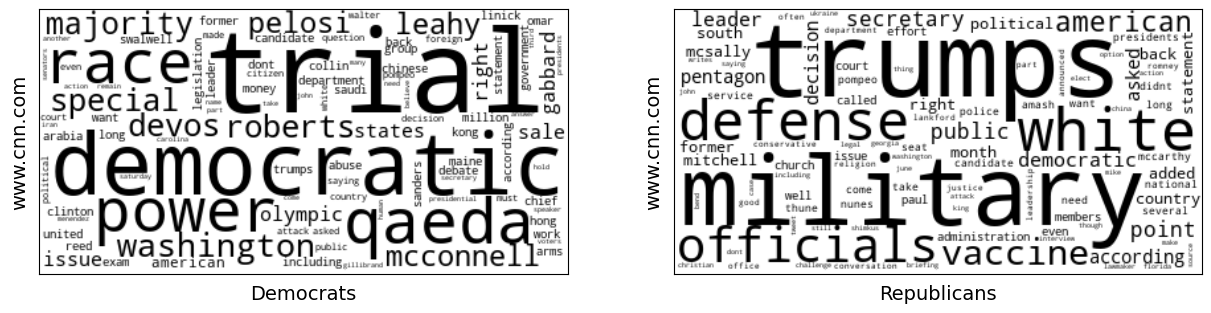

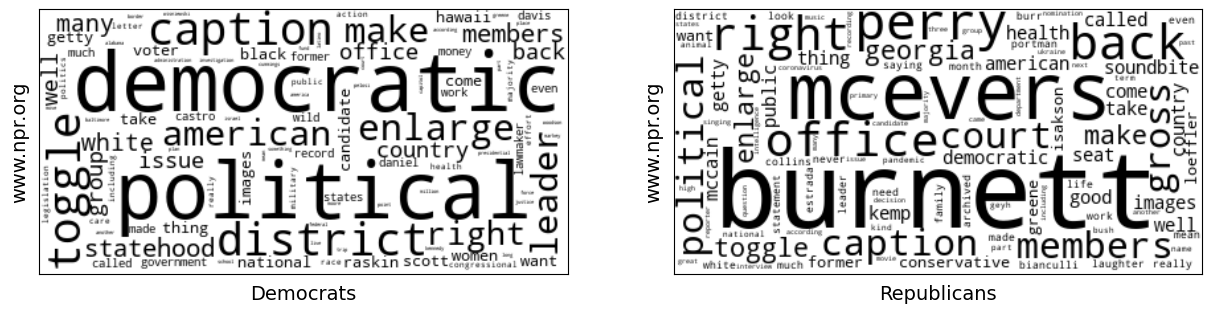

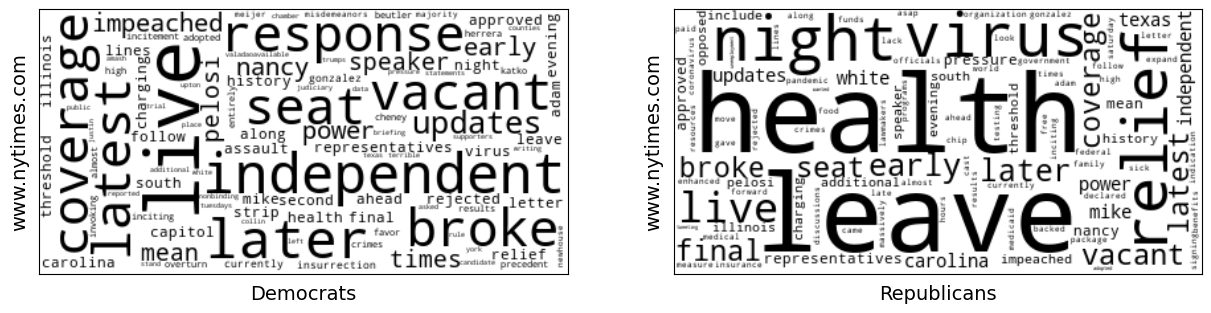

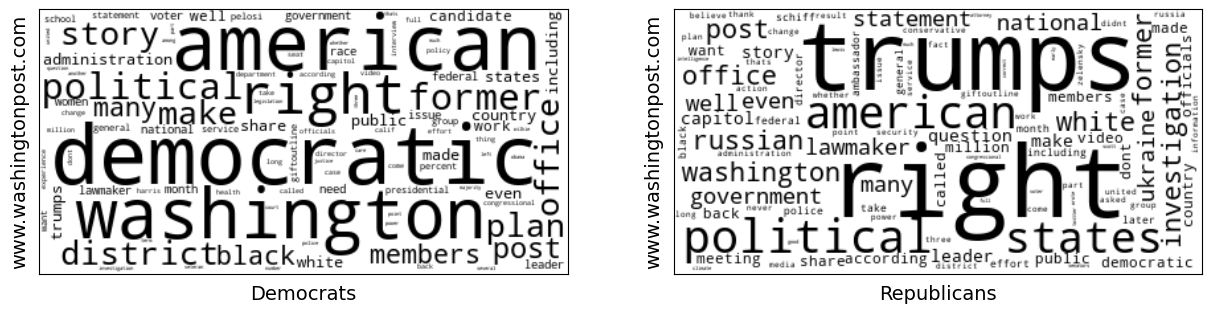

In [15]:
from nltk.corpus import stopwords
### Defining stopwords
stopwords = stopwords.words('english')
words = 'articles, pence, invoke, rice, support, senator, election, committee, show, carol, absentee, inquiry, expected, member, week, impeach, amendment, total, resolution, every, first, says, tuesday, friday, monday, thursday, report, years, kinzinger, vice, representative, gift, campaign, kelly, party, comment, mueller, voted, voting, votes, needed, calling, note, bill, pass, 25th, wednesday, buttigieg, image'
other_stopwords = ['bolton','call','official','donald','know','news','impeachment','biden','esper','last','people','going','think','told','article','time','year','state','democrats','republicans','said','president', 'vote', 'senate', 'congress', 'house', 'democrat', 'republican','npr','say','advertisement','trump']
stopwords.extend(other_stopwords)
stopwords.extend(words.split(', '))
top5 = ['abcnews.go.com', 'www.cnn.com', 'www.npr.org',  'www.nytimes.com', 'www.washingtonpost.com']


j = 0
for i, newspaper in enumerate(top5):
    
    list_of_wordsclouds = make_wordcloud(news_party[j:j+2], stopwords)
    j += 2
    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(15, 20));
    axs[0].imshow(list_of_wordsclouds[0], interpolation='bilinear');
    axs[0].set_xlabel('Democrats', fontsize = 14)
    axs[0].set_ylabel(top5[i], fontsize = 14)

    axs[1].imshow(list_of_wordsclouds[1], interpolation='bilinear');
    axs[1].set_xlabel('Republicans', fontsize = 14)
    axs[1].set_ylabel(top5[i], fontsize = 14)

    axs[0].set_yticklabels([]);
    axs[0].set_xticklabels([]);
    axs[1].set_yticklabels([]);
    axs[1].set_xticklabels([]);
    axs[0].set_xticks([]);
    axs[0].set_yticks([]);
    axs[1].set_xticks([]);
    axs[1].set_yticks([]);
    plt.show()


In [16]:
wordcloudss = []
j = 0
for i, newspaper in enumerate(top5):
    
    list_of_wordsclouds = make_wordcloud(news_party[j:j+2], stopwords)
    if i in [1,3,4]:
        wordcloudss.append(list_of_wordsclouds)   
    j += 2


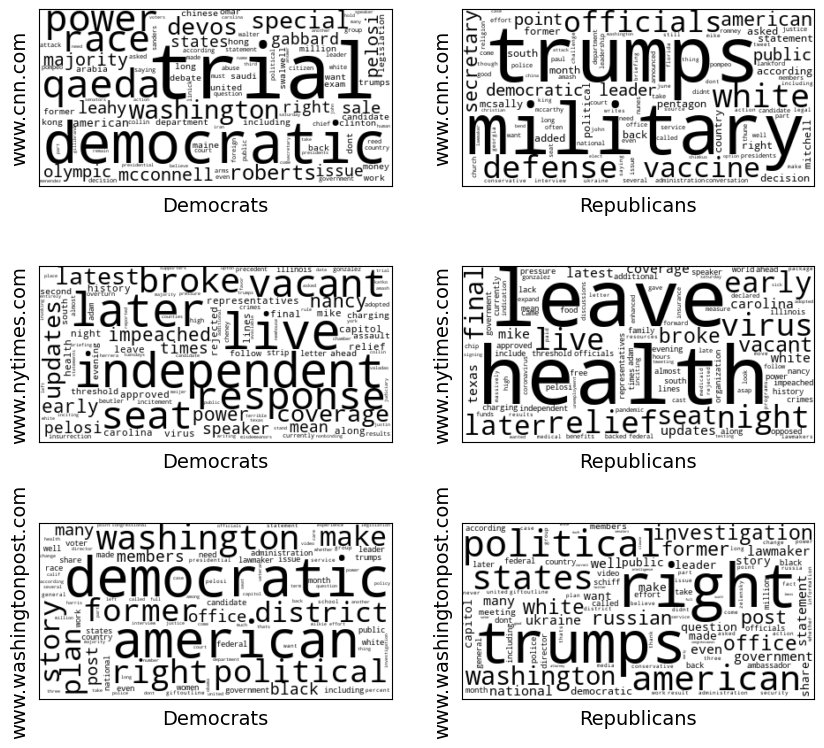

In [17]:
news3 = ['www.cnn.com', 'www.nytimes.com', 'www.washingtonpost.com']
fig, axs = plt.subplots(3, 2, figsize=(10, 10));

for i,name in enumerate(news3):
    axs[i,0].imshow(wordcloudss[i][0], interpolation='bilinear');
    axs[i,0].set_xlabel('Democrats', fontsize = 14)
    axs[i,0].set_ylabel(name, fontsize = 14)

    axs[i,1].imshow(wordcloudss[i][1], interpolation='bilinear');
    axs[i,1].set_xlabel('Republicans', fontsize = 14)
    axs[i,1].set_ylabel(name, fontsize = 14)

    axs[i,0].set_yticklabels([]);
    axs[i,0].set_xticklabels([]);
    axs[i,1].set_yticklabels([]);
    axs[i,1].set_xticklabels([]);
    axs[i,0].set_xticks([]);
    axs[i,0].set_yticks([]);
    axs[i,1].set_xticks([]);
    axs[i,1].set_yticks([]);

fig.subplots_adjust(hspace=0.0)
plt.show()


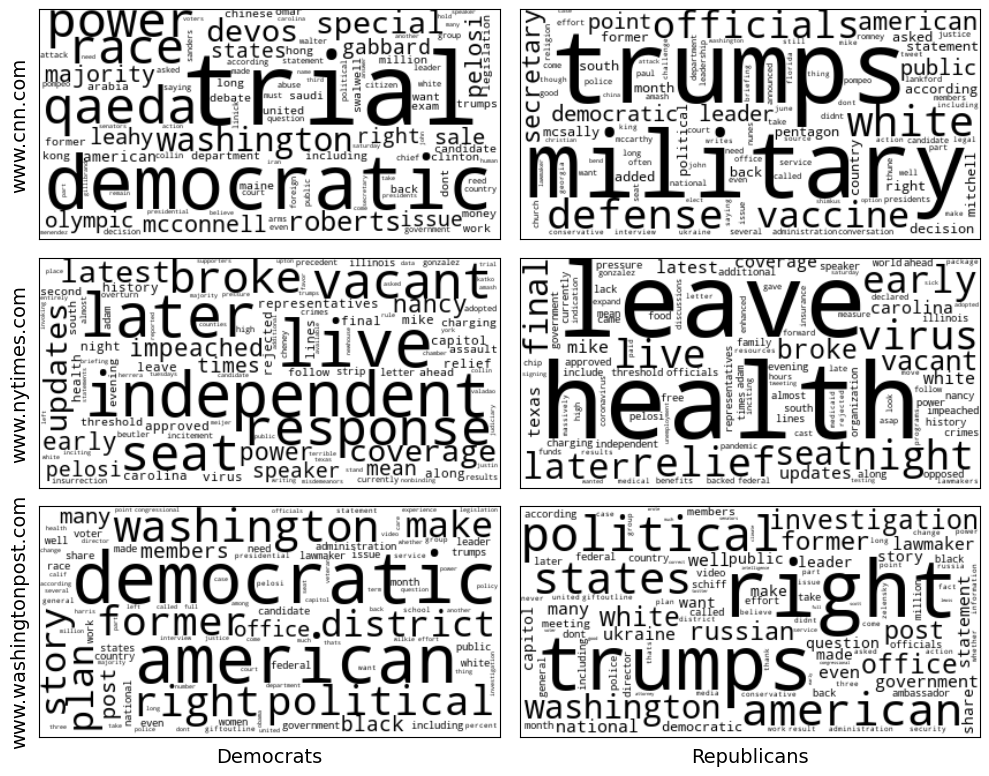

In [18]:
news3 = ['www.cnn.com', 'www.nytimes.com', 'www.washingtonpost.com']
fig, axs = plt.subplots(3, 2, figsize=(10, 8.));
axs[0,0].imshow(wordcloudss[0][0], interpolation='bilinear');
#axs[0,0].set_xlabel('Democrats', fontsize = 14)
axs[0,0].set_ylabel(news3[0], fontsize = 14)
axs[0,0].set_yticklabels([]);
axs[0,0].set_xticklabels([]);
axs[0,0].set_xticks([]);
axs[0,0].set_yticks([]);

axs[0,1].imshow(wordcloudss[0][1], interpolation='bilinear');
#axs[0,1].set_xlabel('Republicans', fontsize = 14)
#axs[0,1].set_ylabel(news3[0], fontsize = 14)
axs[0,1].set_yticklabels([]);
axs[0,1].set_xticklabels([]);
axs[0,1].set_xticks([]);
axs[0,1].set_yticks([]);

axs[1,0].imshow(wordcloudss[1][0], interpolation='bilinear');
#axs[1,0].set_xlabel('Democrats', fontsize = 14)
axs[1,0].set_ylabel(news3[1], fontsize = 14)
axs[1,0].set_yticklabels([]);
axs[1,0].set_xticklabels([]);
axs[1,0].set_xticks([]);
axs[1,0].set_yticks([]);

axs[1,1].imshow(wordcloudss[1][1], interpolation='bilinear');
#axs[1,1].set_xlabel('Republicans', fontsize = 14)
#axs[1,1].set_ylabel(news3[1], fontsize = 14)
axs[1,1].set_yticklabels([]);
axs[1,1].set_xticklabels([]);
axs[1,1].set_xticks([]);
axs[1,1].set_yticks([]);

axs[2,0].imshow(wordcloudss[2][0], interpolation='bilinear');
axs[2,0].set_xlabel('Democrats', fontsize = 14)
axs[2,0].set_ylabel(news3[2], fontsize = 14)
axs[2,0].set_yticklabels([]);
axs[2,0].set_xticklabels([]);
axs[2,0].set_xticks([]);
axs[2,0].set_yticks([]);

axs[2,1].imshow(wordcloudss[2][1], interpolation='bilinear');
axs[2,1].set_xlabel('Republicans', fontsize = 14)
#axs[2,1].set_ylabel(news3[2], fontsize = 14)
axs[2,1].set_yticklabels([]);
axs[2,1].set_xticklabels([]);
axs[2,1].set_xticks([]);
axs[2,1].set_yticks([]);

fig.subplots_adjust(hspace=0.0)
fig.tight_layout()
plt.savefig('TF-IDF.png')
plt.show()